In [241]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [242]:
def create_data(n_patch, n_points, true_points, test_data=False, normalize=True, rseed=12):
  '''
  Arguments:
  n_patch : number of patches (n_patch x n_patch)
  n_points : number of points per patch
  true_points: number of points for true patch cluster
  normalize: if True then return normalized data

  '''
  np.random.seed(rseed)
  x_min = 0
  x_max = 1

  y_min = 0 
  y_max = 1
  csize = n_points

  X = []
  Y = []
  k = 2 
  # 10x10 patch of clusters
  for i in range(n_patch):
    for j in range(n_patch):
      if (i == 3 and j == 0):
        #print(x_min,x_max,y_min,y_max)
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(true_points,2)))
        labels = np.zeros(true_points)
        Y.append(labels)
      elif (i==3 and j==1):
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(true_points,2)))
        labels = np.ones(true_points)
        Y.append(labels)
      else:
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(csize,2)))
        #labels = np.random.randint(0,2,csize)
        labels = np.ones(csize)*int(k)
        Y.append(labels)
        k = k+1
      x_min += 1.5
      x_max += 1.5
    x_min = 0
    x_max = 1
    y_min += 1.5
    y_max += 1.5
  X = np.concatenate(X,axis=0)
  Y = np.concatenate(Y,axis=0)

  if normalize ==True:
    X = ( X - np.mean(X,axis =0 ) ) / np.std(X)
  idx = np.logical_or(Y==0,Y==1)
  # print("no of corrupted data points",sum(~idx))

  return X, Y

In [243]:
x,y = create_data(n_patch = 7, n_points= 30, true_points = 30, test_data=False, normalize=True, rseed=12)

In [244]:
np.unique(y)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48.])

In [245]:
np.random.seed(12)
# y = np.random.randint(0,10,5000)
idx= []
for i in range(49):
    print(i,sum(y==i))
    idx.append(y==i)

0 30
1 30
2 30
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 30
20 30
21 30
22 30
23 30
24 30
25 30
26 30
27 30
28 30
29 30
30 30
31 30
32 30
33 30
34 30
35 30
36 30
37 30
38 30
39 30
40 30
41 30
42 30
43 30
44 30
45 30
46 30
47 30
48 30


In [246]:
color = ['blue','orange','brown']

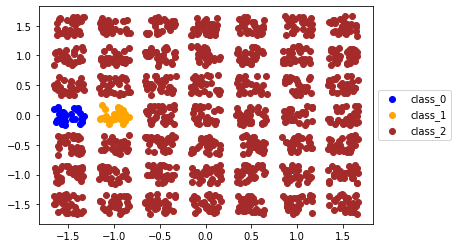

In [247]:
for i in range(49):
  if(i==0):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[0])
  elif (i==1):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[1])
  elif (i==2):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[2])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1], c = color[2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [248]:
bg_idx = []
for i in range(2,49,1):
  bg_idx.append(np.where(idx[i] == True)[0])
# bg_idx = [ np.where(idx[3] == True)[0], 
#           np.where(idx[4] == True)[0], 
#           np.where(idx[5] == True)[0],
#           np.where(idx[6] == True)[0], 
#           np.where(idx[7] == True)[0], 
#           np.where(idx[8] == True)[0],
#           np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(1410,)

In [249]:
np.unique(bg_idx).shape

(1410,)

In [250]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [251]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[ 4.50388348e-17, -3.30704731e-17]]),
 array([[-0.0527468 , -0.00040089]]))

In [252]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [253]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[1.01448168, 0.97953861]]))

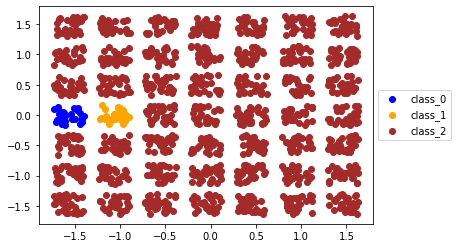

In [254]:
for i in range(49):
  if(i==0):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[0])
  elif (i==1):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[1])
  elif (i==2):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[2])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1], c = color[2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [255]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,49)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 4 present at 0
background 5 present at 1
background 24 present at 2
background 7 present at 3
background 27 present at 4
background 13 present at 5
foreground 1 present at 6
background 2 present at 7
background 42 present at 8
(9, 2)
1 6


In [256]:
a.shape

(9, 2)

In [257]:
desired_num = 3000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,49)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(a)
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [258]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [259]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(3000, array([[-1.60752251, -0.10334498],
        [-1.42771166, -1.62391778],
        [-0.04282785, -1.49612804],
        [-0.45741618, -0.85572753],
        [-0.64535272, -0.10283582],
        [-0.13184325,  0.96870073],
        [ 1.56857163, -1.5958625 ],
        [ 1.07026967,  0.14068521],
        [-1.06496041, -1.34451686]]))

In [260]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [261]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1500], mosaic_label[0:1500] , fore_idx[0:1500])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [262]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1500:3000], mosaic_label[1500:3000] , fore_idx[1500:3000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [263]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(2, 64)
    self.fc2 = nn.Linear(64, 2)
    # self.fc3 = nn.Linear(10, 1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,2], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    # print(x.shape, z.shape)
    for i in range(9):
      # print(z[:,i].shape)
      # print(self.helper(z[:,i])[:,0].shape)
      x[:,i] = self.helper(z[:,i])[:,0]
    # print(x.shape, z.shape)
    x = F.softmax(x,dim=1)
    # print(x.shape, z.shape)
    # x1 = x[:,0]
    # print(torch.mul(x[:,0],z[:,0]).shape)

    for i in range(9):            
      # x1 = x[:,i]          
      y = y + torch.mul(x[:,i,None],z[:,i])

    # print(x.shape, y.shape)
    return x, y
    
  def helper(self, x):
    x = x.view(-1, 2)
    x = F.relu(self.fc1(x))
    x = (self.fc2(x))

    return x

In [264]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 2)
    # self.fc2 = nn.Linear(64, 2)

  def forward(self, x):
    x = x.view(-1, 2)
    # x = F.relu(self.fc1(x))
    x = (self.fc1(x))
    return x

In [265]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [266]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to("cuda")

In [267]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.001 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.001 ) #, momentum=0.9)

In [268]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [269]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)
    # print(predicted.shape)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      # print(focus, fore_idx[j], predicted[j])
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 1000 train images: 49 %
total correct 744
total train set images 1500
focus_true_pred_true 0 =============> FTPT : 0 %
focus_false_pred_true 744 =============> FFPT : 49 %
focus_true_pred_false 0 =============> FTPF : 0 %
focus_false_pred_false 756 =============> FFPF : 50 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1500
1500


In [270]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 1000 test images: 52 %
total correct 782
total train set images 1500
focus_true_pred_true 0 =============> FTPT : 0 %
focus_false_pred_true 782 =============> FFPT : 52 %
focus_true_pred_false 0 =============> FTPF : 0 %
focus_false_pred_false 718 =============> FFPF : 47 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1500


In [271]:
nos_epochs = 1000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 3
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.001):
      break;

  if epoch % 5 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    # print("="*20)
    # print("Train FTPT : ", col4)
    # print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # print("Test FTPT : ", col10)
    # print("Test FFPT : ", col11)
    # print("="*20)
    
print('Finished Training')

[1,     3] loss: 0.707
[1,     6] loss: 0.712
[2,     3] loss: 0.703
[2,     6] loss: 0.709
[3,     3] loss: 0.703
[3,     6] loss: 0.703
[4,     3] loss: 0.698
[4,     6] loss: 0.703
[5,     3] loss: 0.699
[5,     6] loss: 0.699
[6,     3] loss: 0.696
[6,     6] loss: 0.700
[7,     3] loss: 0.696
[7,     6] loss: 0.696
[8,     3] loss: 0.693
[8,     6] loss: 0.698
[9,     3] loss: 0.694
[9,     6] loss: 0.695
[10,     3] loss: 0.690
[10,     6] loss: 0.698
[11,     3] loss: 0.692
[11,     6] loss: 0.694
[12,     3] loss: 0.695
[12,     6] loss: 0.691
[13,     3] loss: 0.693
[13,     6] loss: 0.691
[14,     3] loss: 0.691
[14,     6] loss: 0.692
[15,     3] loss: 0.688
[15,     6] loss: 0.693
[16,     3] loss: 0.690
[16,     6] loss: 0.689
[17,     3] loss: 0.686
[17,     6] loss: 0.691
[18,     3] loss: 0.690
[18,     6] loss: 0.685
[19,     3] loss: 0.689
[19,     6] loss: 0.684
[20,     3] loss: 0.685
[20,     6] loss: 0.686
[21,     3] loss: 0.684
[21,     6] loss: 0.684
[22,     3

In [272]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [273]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [274]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [275]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1500,0,744,0,756
1,1,0,1500,0,744,0,756
2,6,0,1500,7,757,4,732
3,11,0,1500,19,757,10,714
4,16,17,1483,83,730,29,658
...,...,...,...,...,...,...,...
196,976,966,534,749,745,4,2
197,981,967,533,749,745,4,2
198,986,968,532,749,745,4,2
199,991,969,531,749,745,4,2


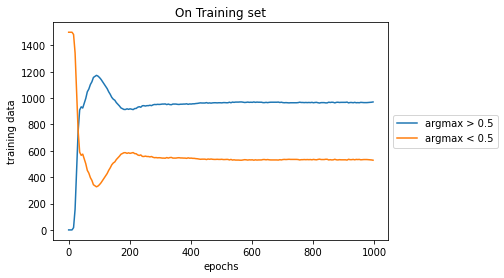

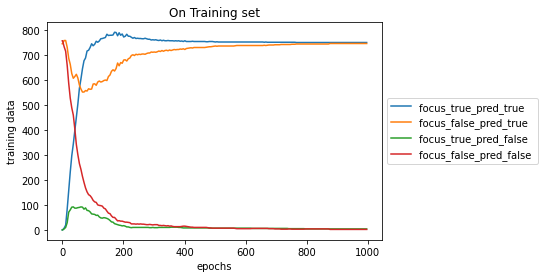

In [276]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [277]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1500,0,782,0,718
1,1,0,1500,0,776,0,724
2,6,0,1500,6,775,2,717
3,11,1,1499,19,761,8,712
4,16,31,1469,84,699,35,682
...,...,...,...,...,...,...,...
196,976,1006,494,788,708,2,2
197,981,1005,495,788,708,2,2
198,986,1006,494,788,708,2,2
199,991,1007,493,788,709,2,1


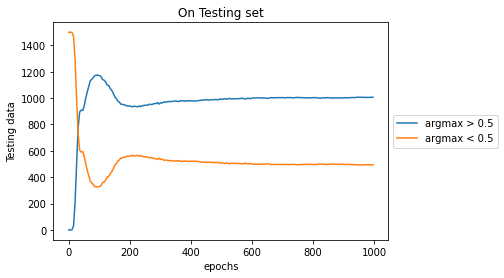

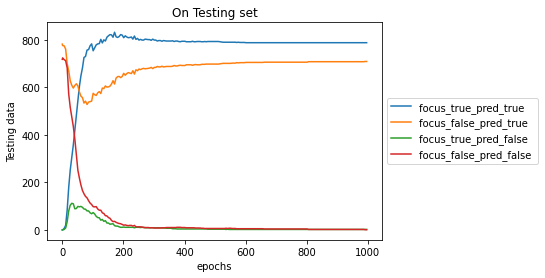

In [278]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [279]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 99 %
total correct 1494
total train set images 1500
focus_true_pred_true 749 =============> FTPT : 49 %
focus_false_pred_true 745 =============> FFPT : 49 %
focus_true_pred_false 4 =============> FTPF : 0 %
focus_false_pred_false 2 =============> FFPF : 0 %
argmax_more_than_half ==================>  970
argmax_less_than_half ==================>  530


In [280]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 10000 test images: 99 %
total correct 1496
total train set images 1500
focus_true_pred_true 788 =============> FTPT : 52 %
focus_false_pred_true 708 =============> FFPT : 47 %
focus_true_pred_false 2 =============> FTPF : 0 %
focus_false_pred_false 2 =============> FFPF : 0 %
argmax_more_than_half ==================>  1009
argmax_less_than_half ==================>  491


In [281]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 30000 train images: 99 %
total correct 1494
total train set images 1500


In [282]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 99 %
total correct 1496
total train set images 1500
